In [1]:
import numpy as np
import tensorrt as trt
from cuda import cuda, cudart
from typing import Optional, List
import ctypes
import os

## 1. 建立 Logger (日志记录器)

可选参数：`Logger.VERBOSE`、`Logger.INFO`、`Logger.WARNING`、`Logger.ERROR`、`Logger.INTERNAL_ERROR`、`Logger.UNKNOWN` 对应日志输出的详细或严重程度

In [2]:
logger = trt.Logger(trt.Logger.ERROR) 

## 2. 建立 Builder 和 BuilderConfig

Builder 类是 TensorRT 中的主要类之一，用于构建和优化 TensorRT 引擎。在创建 Builder 对象时，需要传入一个 Logger 对象，用于记录日志和错误信息。Builder 可以使用 BuilderConfig 对象来设置一些元数据，如最大批处理大小、最大 workspace 大小等等。

BuilderConfig 类是用于设置构建 TensorRT 引擎时的一些元数据的类。它可以设置一些参数，例如最大批处理大小、最大 workspace 大小、最大延迟等等。BuilderConfig 还可以设置 TensorRT 引擎的精度（FP32、FP16 或 INT8）和优化方式（如批处理大小、数据类型等）。

In [3]:
builder = trt.Builder(logger)                                           # create Builder
config = builder.create_builder_config()                                # create BuidlerConfig to set meta data of the network

## 3. 创建 Network

Network 的构建主要分为两种方法：

使用 Parser (TF/Torch -> ONNX -> TensorRT)
* 流程成熟，ONNX 通用性好，方便网络调整，兼顾效率性能

使用 TensorRT 原生 API 搭建网络
* 性能最优，精细网络控制，兼容性最好

由于使用 API 搭建网络开发效率较低，较复杂，所以一般采用使用 Parser 的方式搭建网络。

In [4]:
onnxFile = "./model.onnx"
nHeight = 28
nWidth = 28

# 创建 Network 使用 Explicit Batch 模式，所有的维度都是显式的并且是动态的，意思是在执行的时候，每一维度的长度都可以变化
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))

# 对 ONNX 进行模型解析
parser = trt.OnnxParser(network, logger)
with open(onnxFile, "rb") as model:
    if not parser.parse(model.read()):
        print("Failed parsing .onnx file!")
        for error in range(parser.num_errors):
            print(parser.get_error(error))
        exit()
    print("Succeeded parsing .onnx file!")

# 由于使用 dynamic shape 需要 profile 指定输入范围，并让 profile 优化不同 shape 对应不同的 kernel
profile = builder.create_optimization_profile()

# 获取网络的输入张量
inputTensor = network.get_input(0)

# 设置优化配置文件中输入张量的形状，包括最小、最优和最大形状
profile.set_shape(inputTensor.name, [1, 1, nHeight, nWidth], [4, 1, nHeight, nWidth], [8, 1, nHeight, nWidth])

# 将优化配置文件添加到TensorRT配置中
config.add_optimization_profile(profile) 

# 移除输出张量 "y" 的标记 原 network.get_output(0).name == 'y'
network.unmark_output(network.get_output(0))  

Succeeded parsing .onnx file!


---
1. 使用build_engine函数构建了一个TensorRT引擎（engine）。引擎（engine）是一个已编译和优化的网络表示形式。引擎通常是存储在内存中的对象，可以直接用于推理过程，而无需重新构建和优化网络。引擎还可以通过将其序列化为一个计划（plan）进行持久化。

2. 使用build_serialized_network函数构建了一个可序列化的计划（plan）。一个计划（plan）是一个包含了网络结构和权重信息的序列化二进制对象。该计划可以保存到磁盘中，以便在以后的时间加载和重用。

总结来说，计划（plan）是一种可序列化的网络表示形式，可以保存到磁盘并在需要时加载和重用。引擎（engine）是一个已编译和优化的网络对象，可以直接用于推理过程，无需重新构建和优化网络。通常，你可以通过构建引擎（engine）来进行实时推理，而使用计划（plan）可以在不同的时间和设备上加载和重用网络。

## (4.直接生成 Engine)

In [5]:
engine = builder.build_engine(network, config)
with open('model.engine', "wb") as f:
    f.write(engine.serialize())

/tmp/ipykernel_10745/4271150106.py:1: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


## 4. 生成网络的 TRT 内部表示 serialized network 

In [6]:
trtFile = "model.plan"

# create a serialized network
engineString = builder.build_serialized_network(network, config)        
if engineString == None:
    print("Failed building serialized engine!")
print("Succeeded building serialized engine!")

# write the serialized netwok into a .plan file
with open(trtFile, "wb") as f:                                          
    f.write(engineString)
    print("Succeeded saving .plan file!")

Succeeded building serialized engine!
Succeeded saving .plan file!


## 5. 生成 Engine

In [7]:
# trtFile = "model.plan"
# if os.path.isfile(trtFile):                                                 # load serialized network and skip building process if .plan file existed
#     with open(trtFile, "rb") as f:
#         engineString = f.read()
#     if engineString == None:
#         print("Failed getting serialized engine!")
#     print("Succeeded getting serialized engine!")

engine = trt.Runtime(logger).deserialize_cuda_engine(engineString)

if engine == None:
    print("Failed building engine!")
print("Succeeded building engine!")

Succeeded building engine!


In [8]:
for idx in range(engine.num_bindings):
    
    name = engine.get_tensor_name (idx)
    is_input = engine.get_tensor_mode (name)
    op_type = engine.get_tensor_dtype(name)
    shape = engine.get_tensor_shape(name)

    print('input id:',idx,'   is input: ', is_input,'  binding name:', name, '  shape:', shape, 'type: ', op_type)

input id: 0    is input:  TensorIOMode.INPUT   binding name: x   shape: (-1, 1, 28, 28) type:  DataType.FLOAT
input id: 1    is input:  TensorIOMode.OUTPUT   binding name: z   shape: (-1,) type:  DataType.INT32


## 6. 创建 buffers
用于申请 inputs / outputs 的显存

In [9]:
# Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
# If engine uses dynamic shapes, specify a profile to find the maximum input & output size.

def check_cuda_err(err):
    if isinstance(err, cuda.CUresult):
        if err != cuda.CUresult.CUDA_SUCCESS:
            raise RuntimeError("Cuda Error: {}".format(err))
    if isinstance(err, cudart.cudaError_t):
        if err != cudart.cudaError_t.cudaSuccess:
            raise RuntimeError("Cuda Runtime Error: {}".format(err))
    else:
        raise RuntimeError("Unknown error type: {}".format(err))

def cuda_call(call):
    err, res = call[0], call[1:]
    check_cuda_err(err)
    if len(res) == 1:
        res = res[0]
    return res

def load_test_case(pagelocked_buffer, img):
    copy_size = img.ravel().size
    np.copyto(pagelocked_buffer[:int(copy_size)], img.ravel())
    
class HostDeviceMem:
    """Pair of host and device memory, where the host memory is wrapped in a numpy array"""
    def __init__(self, size: int, dtype: np.dtype):
        nbytes = size * dtype.itemsize
        host_mem = cuda_call(cudart.cudaMallocHost(nbytes))
        pointer_type = ctypes.POINTER(np.ctypeslib.as_ctypes_type(dtype))

        self._host = np.ctypeslib.as_array(ctypes.cast(host_mem, pointer_type), (size,))
        self._device = cuda_call(cudart.cudaMalloc(nbytes))
        self._nbytes = nbytes

    @property
    def host(self) -> np.ndarray:
        return self._host

    @host.setter
    def host(self, arr: np.ndarray):
        if arr.size > self.host.size:
            raise ValueError(
                f"Tried to fit an array of size {arr.size} into host memory of size {self.host.size}"
            )
        np.copyto(self.host[:arr.size], arr.flat, casting='safe')

    @property
    def device(self) -> int:
        return self._device

    @property
    def nbytes(self) -> int:
        return self._nbytes

    def __str__(self):
        return f"Host:\n{self.host}\nDevice:\n{self.device}\nSize:\n{self.nbytes}\n"

    def __repr__(self):
        return self.__str__()

    def free(self):
        cuda_call(cudart.cudaFree(self.device))
        cuda_call(cudart.cudaFreeHost(self.host.ctypes.data))
        
def allocate_buffers(engine: trt.ICudaEngine, profile_idx: Optional[int] = None, shape_idx = -1):
    inputs = []
    outputs = []
    bindings = []
    
    batch_size = 0
    
    stream = cuda_call(cudart.cudaStreamCreate())
    tensor_names = [engine.get_tensor_name(i) for i in range(engine.num_io_tensors)]
    
    for binding in tensor_names:
        # get_tensor_profile_shape returns (min_shape, optimal_shape, max_shape)
        # Pick out the max shape to allocate enough memory for the binding.
        shape = engine.get_tensor_shape(binding) if profile_idx is None else engine.get_tensor_profile_shape(binding, profile_idx)[shape_idx]
        if engine.get_tensor_mode(binding) == trt.TensorIOMode.INPUT:
            batch_size = shape[0]
        if engine.get_tensor_mode(binding) == trt.TensorIOMode.OUTPUT:
            shape = (batch_size,)
        # print("shape", binding, shape)
        
        shape_valid = np.all([s >= 0 for s in shape])
        if not shape_valid and profile_idx is None:
            raise ValueError(f"Binding {binding} has dynamic shape, " +\
                "but no profile was specified.")
        size = trt.volume(shape)
        if engine.has_implicit_batch_dimension:
            size *= engine.max_batch_size
        dtype = np.dtype(trt.nptype(engine.get_tensor_dtype(binding)))

        # print("size", size)
        # Allocate host and device buffers
        bindingMemory = HostDeviceMem(size, dtype)

        # Append the device buffer to device bindings.
        bindings.append(int(bindingMemory.device))

        # Append to the appropriate list.
        if engine.get_tensor_mode(binding) == trt.TensorIOMode.INPUT:
            inputs.append(bindingMemory)
        else:
            outputs.append(bindingMemory)
    return inputs, outputs, bindings, stream

def free_buffers(inputs: List[HostDeviceMem], outputs: List[HostDeviceMem], stream: cudart.cudaStream_t):
    for mem in inputs + outputs:
        mem.free()
    cuda_call(cudart.cudaStreamDestroy(stream))

## 7. 推理函数

In [10]:
def _do_inference_base(inputs, outputs, stream, execute_async):
    # Transfer input data to the GPU.
    kind = cudart.cudaMemcpyKind.cudaMemcpyHostToDevice
    [cuda_call(cudart.cudaMemcpyAsync(inp.device, inp.host, inp.nbytes, kind, stream)) for inp in inputs]
    # Run inference.
    execute_async()
    # Transfer predictions back from the GPU.
    kind = cudart.cudaMemcpyKind.cudaMemcpyDeviceToHost
    [cuda_call(cudart.cudaMemcpyAsync(out.host, out.device, out.nbytes, kind, stream)) for out in outputs]
    # Synchronize the stream
    cuda_call(cudart.cudaStreamSynchronize(stream))
    # Return only the host outputs.
    return [out.host for out in outputs]

def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    def execute_async():
        context.execute_async(batch_size=batch_size, bindings=bindings, stream_handle=stream)
    return _do_inference_base(inputs, outputs, stream, execute_async)

def do_inference_v2(context, bindings, inputs, outputs, stream):
    def execute_async():
        context.execute_async_v2(bindings=bindings, stream_handle=stream)
    return _do_inference_base(inputs, outputs, stream, execute_async)

## 测试-对单张图片进行推理

In [11]:
from LoadMnistData import MyData
import torch

DATA_PATH = "../data/MNIST/"

testDataset = MyData(datapath = DATA_PATH, isTrain = False)

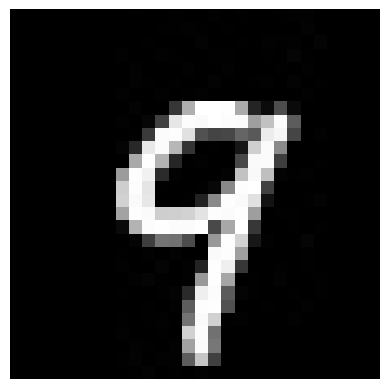

In [12]:
import matplotlib.pyplot as plt

img_1 = testDataset[12][0] # torch.Size([1, 28, 28])
# 将 Torch 张量转换为 NumPy 数组
img_np = img_1.squeeze().numpy()

# 使用 Matplotlib 显示图像
plt.imshow(img_np, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

In [13]:
with engine.create_execution_context() as context:
    inputs, outputs, bindings, stream = allocate_buffers(engine, 0)
    context.set_optimization_profile_async(0, stream)
    
    data = img_1.unsqueeze(0).numpy()
    context.set_input_shape('x', data.shape)
    
    inputs[0].host = data
    # load_test_case(inputs[0].host, data)
    
    trt_outputs = do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
    # result = trt_outputs
    print("result", trt_outputs[0][0])
    

result 9


In [14]:
del context

In [15]:
free_buffers(inputs, outputs, stream)

## 测试-模型精度

In [16]:
from LoadMnistData import MyData
import torch

BATCH_SIZE = 8
DATA_PATH = "../data/MNIST/"

testDataset = MyData(datapath = DATA_PATH, isTrain = False)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
inputs, outputs, bindings, stream = allocate_buffers(engine, 0)

In [18]:
def test_tensorrt_acc(engine, test_loader):
    correct = 0
    with engine.create_execution_context() as context:
        context.set_optimization_profile_async(0, stream)
        for _, (image, label) in enumerate(test_loader):
            image = image.numpy()
            context.set_input_shape('x', image.shape)
            inputs[0].host = image
            # load_test_case(inputs[0].host, image)
            preds = do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)[0]
            label = np.argmax(label.numpy(), axis=-1)
            count = 0
            for i in range(len(label)):
                if label[i] == preds[i]:
                    count += 1
            correct += count
        del context
    print('\nTest set: Accuracy: {:.3f}%\n'.format(100. * correct / len(test_loader.dataset)))
            

In [19]:
test_tensorrt_acc(engine, testLoader)


Test set: Accuracy: 96.300%



In [20]:
free_buffers(inputs, outputs, stream)

## 测试-推理速度

In [21]:
inputs, outputs, bindings, stream = allocate_buffers(engine, 0)

In [22]:
import time
def test_tensorrt_for_test(engine):
    i = 0
    total_time_span = 0
    with engine.create_execution_context() as context:
        context.set_optimization_profile_async(0, stream)
        # warm up
        input_shape = engine.get_tensor_shape('x')
        input_shape[0] = engine.get_tensor_profile_shape('x', 0)[-1][0]
        print('input_shape', input_shape)
        
        data = np.random.rand(*input_shape).astype(np.float32)
        
        context.set_input_shape('x', data.shape)
        # inputs[0].host = data
        load_test_case(inputs[0].host, data)
        for i in range(10):
            pred = do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        for i in range(1000):
#             data = np.random.rand(*input_shape).astype(np.float32)
#             load_test_case(inputs[0].host, data)
            # =======================================
            # The common do_inference function will return a list of outputs - we only have one in this case.

            start_time = time.time()
            pred = do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
            time_span = time.time() - start_time

            total_time_span += time_span
        total_time_span /= 1000.0
        print('total_time_span', total_time_span)
        # del context if not reuse
        del context

In [23]:
test_tensorrt_for_test(engine)

input_shape (8, 1, 28, 28)
total_time_span 0.00010671162605285645


In [24]:
free_buffers(inputs, outputs, stream)

In [25]:
import torch.nn.functional as F

# 构造模型
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, (5, 5), padding=(2, 2), bias=True)
        self.conv2 = torch.nn.Conv2d(32, 64, (5, 5), padding=(2, 2), bias=True)
        self.fc1 = torch.nn.Linear(64 * 7 * 7, 1024, bias=True)
        self.fc2 = torch.nn.Linear(1024, 10, bias=True)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.reshape(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        z = F.softmax(y, dim=1)
        z = torch.argmax(z, dim=1)
        return y, z
    
model = Net().cuda()

# def test_tensorrt_for_test(engine):

In [26]:
def test_torch_for_test(engine):
    i = 0
    total_time_span = 0
    # warm up
    input_shape = engine.get_tensor_shape('x')
    input_shape[0] = engine.get_tensor_profile_shape('x', 0)[-1][0]
    print('input_shape', input_shape)

    data = torch.rand(*input_shape).cuda()
    # load_test_case(inputs[0].host, data)
    for i in range(10):
        model(data)
    for i in range(100):
#             data = np.random.rand(*input_shape).astype(np.float32)
#             load_test_case(inputs[0].host, data)
        # =======================================
        # The common do_inference function will return a list of outputs - we only have one in this case.

        start_time = time.time()
        model(data)
        time_span = time.time() - start_time

        total_time_span += time_span
    total_time_span /= 100.0
    print('total_time_span', total_time_span)
    # del context if not reuse


In [27]:
test_torch_for_test(engine)

input_shape (8, 1, 28, 28)
total_time_span 0.0003108072280883789
